<a href="https://colab.research.google.com/github/hikmatfarhat-ndu/pytorch/blob/main/detecting-emotions-pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What you will learn
1. Using Kaggle and importing Kaggle datasets
1. Reading a dataset of images using ImageFolder
1. Using Dropout to reduce overfitting

In [7]:
import torch
import torch.nn as nn
import torchvision as vision
from torchvision.transforms import Lambda,Compose,ToTensor,Normalize,Grayscale,ToPILImage
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import sys,os

## The data
The data is stored on Kaggle. If you are running this notebook on 
1. Kaggle do the following
    1. Using the right panel click on "Add Data"
    1. Use the search keywords "manas sambare fer-2013"
    1. Click on the "+"
    1. The data is accessible from "/kaggle/input/fer2013" (see below)
1. Google Colab do the following:
    1. Go to your Kaggle account and click on your profile
    1. Click on "Account"
    1. Toward the middle of the page click on "Create new API token"
    1. A file "kaggle.json" will be downloaded. Remember where it was saved

## If you are running on Kaggle

In [8]:
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB: 
    from google.colab import files
    file=files.upload() # upload the saved kaggle.json
    #### the token can be obtained from your kaggle account by going to settings
    #### in the middle of the page under API there is a create new token
    #### there is also explanation on how to do it
    !mkdir /root/.kaggle
    !mv kaggle.json  /root/.kaggle
    !kaggle datasets download -d msambare/fer2013
    !unzip -q fer2013.zip
    data_path="./"
elif os.environ.get('KAGGLE_KERNEL_RUN_TYPE') is not None:
    data_path="/kaggle/input/fer2013/"
else:
  data_path="./"
  if not os.path.isfile("fer2013.zip"):
    !kaggle datasets download -d msambare/fer2013
    !unzip -q fer2013.zip


## If you are running on Colab

- The ```ImageFolder``` class automatically associates with each image the name of the folder it was found in.
- After you run the cell below, open the folder in the left panel and you will see a directory structure that contains ```train/angry,train,disgust,...```
- Each image in ```train/angry``` will be given the label "angry" (actually 0) and so on.

In [9]:

transform=Compose([Grayscale(),ToTensor()])
dataset_train=datasets.ImageFolder(data_path+"/train",transform=transform)
dataset_test=datasets.ImageFolder(data_path+"/test",transform=transform)

In [10]:
print("There are {} samples each with the following categories \n {}".format(
      len(dataset_train),dataset_train.classes))

There are 28709 samples each with the following categories 
 ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


- Like always we plot the images to get an idea about the data

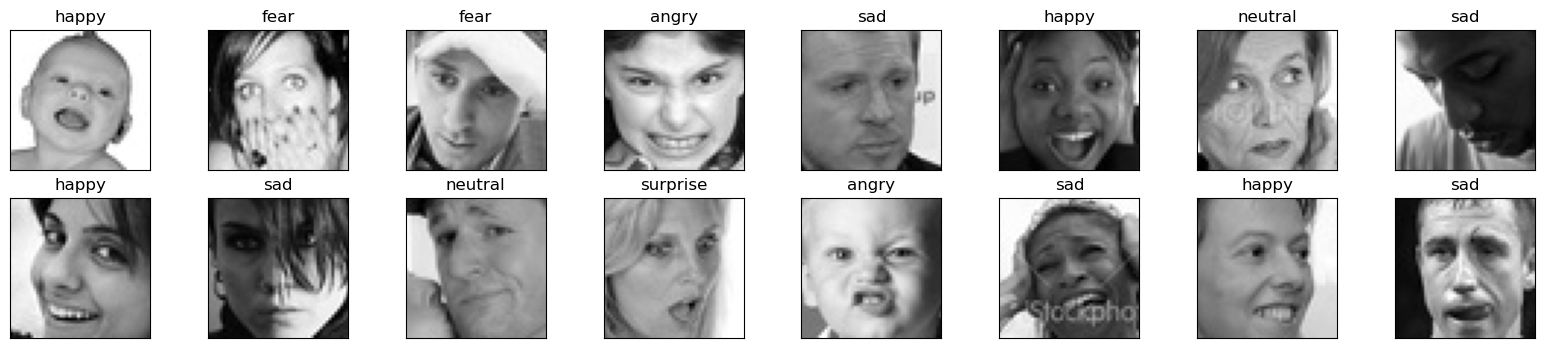

In [11]:
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(20,4))
fig.tight_layout()
#plt.subplots_adjust( wspace=1, hspace=1)
to_image=ToPILImage()
for i in range(16):
            idx=torch.randint(len(dataset_test),size=(1,)).item()
            img,label=dataset_test[idx]
            t=fig.add_subplot(2,8,i+1)
            # set the title of the image equal to its label
            t.set_title(dataset_test.classes[label])
            t.axes.get_xaxis().set_visible(False)
            t.axes.get_yaxis().set_visible(False)
            plt.imshow(to_image(img),cmap='gray')

In [12]:
train_loader=DataLoader(dataset_train,batch_size=64,shuffle=True,num_workers=2,pin_memory=True)
test_loader=DataLoader(dataset_test,batch_size=64,shuffle=False,num_workers=2,pin_memory=True)

## Model

In [13]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu=nn.ReLU()
        self.flatten=nn.Flatten()
        self.conv1=nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3)
        self.conv2=nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3)
        self.pool1=nn.MaxPool2d(kernel_size=2)
        self.drop1=nn.Dropout()
        self.conv3=nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3)
        self.conv4=nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3)
        self.pool2=nn.MaxPool2d(kernel_size=2)
        self.drop2=nn.Dropout()
        self.fc1=nn.Linear(in_features=9*9*256,out_features=1024)
        self.drop3=nn.Dropout()
        self.fc2=nn.Linear(in_features=1024,out_features=7)
    def forward(self,x):
        #input (1,48,48)
        x=self.conv1(x)
        x=self.relu(x)
        #input (32,46,46)
        x=self.conv2(x)
        x=self.relu(x)
        #input (64,44,44)
        x=self.pool1(x)
        x=self.drop1(x)
        
        #input (64,22,22)
        x=self.conv3(x)
        x=self.relu(x)
        #input (128,20,20)
        x=self.conv4(x)
        x=self.relu(x)
        #input (256,18,18)
        x=self.pool2(x)
        x=self.drop2(x)
        #input (256,9,9)
        x=self.flatten(x)
        x=self.fc1(x)
        x=self.relu(x)
        x=self.drop3(x)
        x=self.fc2(x)
        return x

Instantiate mode, optimizer and loss function. Then learning loop.

In [14]:
%%time
import torch.optim as optim
model=Net().cuda()
loss_fn=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters())

from tqdm import tqdm
epochs=10

for epoch in range(epochs):
    print(f"epoch {epoch}:",end=' ')
    train_loader=tqdm(train_loader)
    epoch_loss=0.0
    for imgs,labels in train_loader:
        imgs=imgs.cuda()
        labels=labels.cuda()
        outputs=model(imgs)
        optimizer.zero_grad()
        loss=loss_fn(outputs,labels)
        loss.backward()
        optimizer.step()
        epoch_loss+=loss.item()
    print(epoch_loss)
    
        

epoch 0: 

100%|██████████| 449/449 [00:06<00:00, 66.57it/s]


768.3567068576813
epoch 1: 

100%|██████████| 449/449 [00:06<00:00, 69.26it/s]


674.2854524850845
epoch 2: 

100%|██████████| 449/449 [00:06<00:00, 69.09it/s]


619.3802591562271
epoch 3: 

100%|██████████| 449/449 [00:06<00:00, 68.96it/s]


587.8339634537697
epoch 4: 

100%|██████████| 449/449 [00:06<00:00, 69.00it/s]


561.7595596313477
epoch 5: 

100%|██████████| 449/449 [00:06<00:00, 69.05it/s]


542.281641304493
epoch 6: 

100%|██████████| 449/449 [00:06<00:00, 68.81it/s]


526.7948654294014
epoch 7: 

100%|██████████| 449/449 [00:06<00:00, 68.70it/s]


511.1510736942291
epoch 8: 

100%|██████████| 449/449 [00:06<00:00, 68.71it/s]


494.06473672389984
epoch 9: 

100%|██████████| 449/449 [00:06<00:00, 68.77it/s]

484.7526578307152
CPU times: user 1min 6s, sys: 1.7 s, total: 1min 8s
Wall time: 1min 5s


In [15]:
# save the model to a file
torch.save(model,'model.h5')

Install and use torchmetrics

In [16]:
!pip install torchmetrics
from torchmetrics import ConfusionMatrix
conmat=ConfusionMatrix(task="multiclass",num_classes=7)
conmat=conmat.cuda()

/bin/bash: /home/user/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
DEPRECATION: Loading egg at /home/user/anaconda3/envs/pytorch/lib/python3.11/site-packages/sacremoses-0.0.43-py3.8.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [17]:
# load the model from the file
model=torch.load('model.h5')
total=len(dataset_test)
correct=0
for imgs,labels in test_loader:
    imgs=imgs.cuda()
    labels=labels.cuda()
    outputs=model(imgs)
    _,predicted=torch.max(outputs.data,1)
    tmp=(predicted==labels).sum()
    correct+=tmp
    conmat.update(predicted,labels)
print(correct/total)

tensor(0.5265, device='cuda:0')


In [18]:
import matplotlib.pyplot as plt
import seaborn as sb

<Axes: >

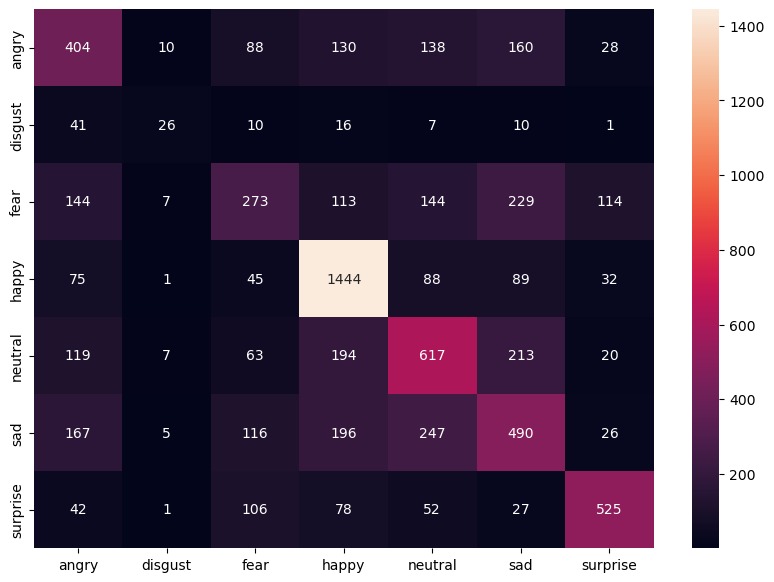

In [19]:
x=conmat.compute().cpu().numpy()
plt.figure(figsize=(10,7))
sb.heatmap(x,xticklabels=dataset_train.classes,yticklabels=dataset_train.classes,annot=True,fmt=".0f")